In [1]:
import os,time
import torch, tables
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
os.environ['CUDA_VISIBLE_DEVICES']='1'

In [3]:
T = 10 # time buckets

hdf5 = tables.open_file('captures/fei/R1_E3_AMES_200min_200f_14l_rgb.h5','r')
hdf5 = hdf5.root

try:
    dataset = np.load('captures/fei/cache.npy')
except FileNotFoundError:

    data = []
    for i in range(7):
        print('.',end='')
        batch = np.array(hdf5['data'][i*400:(i+1)*400])
        batch = batch.reshape(-1,T,int(batch.shape[1]/T),64,64,6).sum(2).astype(np.float32) # binning
        data.append(batch)
        
    dataset = np.concatenate(data,axis=0)
    dataset = np.moveaxis(dataset,[0,1,2,3,4],[0,1,3,4,2])
    np.save('captures/fei/cache.npy', dataset)

# Presented targets

In [4]:
imgs = hdf5["images"][0:100]
y,x = np.where(np.mean(imgs, axis=(0,3))>5)
xleft, xright, ytop, ybot = min(x), max(x), min(y), max(y)

images = hdf5["images"][:,ytop:ybot,xleft:xright]

tiny_images = []
for i in range(len(images)):
    tiny_images.append(cv2.resize(images[i],(64,64)))
images = np.stack(tiny_images)

# Model

In [10]:
class Block(torch.nn.Module):
    def __init__(self, filters):
        super(Block, self).__init__()
        
        self.block = torch.nn.Sequential(
            torch.nn.Conv2d(filters, filters, 3, padding=1, bias=False),
            torch.nn.BatchNorm2d(filters), torch.nn.ReLU(),
            torch.nn.Conv2d(filters, filters, 3, padding=1, bias=False),
            torch.nn.BatchNorm2d(filters))
        
    def forward(self, x):
        return F.relu(x + self.block(x))
    
class ConvNet(torch.nn.Module):
    def __init__(self, filters=128):
        super(ConvNet, self).__init__()
        self.filters = filters
        
        self.conv_in = torch.nn.Conv2d(10*6, filters, 9, padding=4, stride=2, bias=False)
        
        self.resnet = torch.nn.ModuleList()
        for i in range(101): self.resnet.append(Block(filters))
            
        self.conv_out =  torch.nn.ConvTranspose2d(self.filters, 1, 8, stride=8, bias=True)
        self.bias = torch.nn.Parameter(torch.Tensor(64,64))
        
        for name, parm in self.named_parameters():
            if name.endswith('weight'): torch.nn.init.normal_(parm, 0, .01)
            if name.endswith('bias'): torch.nn.init.constant_(parm, 0.0)
    
    def forward(self, x):
        x = x.view(-1,10*6,64,64)[:,:,::4,::4].contiguous()
        zx = F.relu(self.conv_in(x))
        for layer in self.resnet: zx = layer(zx)
        return torch.sigmoid(self.conv_out(zx).squeeze() + self.bias[None,:,:])

# Fit

In [11]:
data = torch.tensor(dataset)/30. # scaling
targets = torch.tensor(images).float().mean(3)/255.

In [12]:
train_data = data[[i for i in range(2800) if (i+1)%5 != 0]]
val_data = data[slice(4,2800,10)]
test_data = data[slice(9,2800,10)]

train_targets = targets[[i for i in range(2800) if (i+1)%5 != 0]]
val_targets = targets[slice(4,2800,10)]
test_targets = targets[slice(9,2800,10)]

In [13]:
batch_size = 50

model = ConvNet().cuda()
count = sum([np.prod(parm.shape) for parm in model.parameters() if parm.requires_grad])
print('Initialized a graph with {} parameters'.format(count))

train_history = []
val_history = []

model.eval()
loss = 0.
for i in np.random.permutation(len(val_data)//batch_size):
    start, end = i*batch_size, (i+1)*batch_size
    x,z = val_data[start:end].cuda(), val_targets[start:end].cuda()
    loss += ((model(x).detach() - z)**2).sum(1).mean()
val_history.append(loss/(len(val_data)//batch_size))
print('Initial Loss: {:2f}'.format(val_history[-1]))

Initialized a graph with 30472193 parameters
Initial Loss: 4.065631


In [14]:
batch_size = 50
optimizer = torch.optim.Adam(model.parameters(), lr=.0003)

try:
    print('epoch\ttrain loss\ttest loss\ttime\t\tutime')
    t0 = time.time()
    for epoch in range(500):
        model.train()
        loss_train = 0
        for i in np.random.permutation(len(train_data)//batch_size):
            start, end = i*batch_size, (i+1)*batch_size
            x,z = train_data[start:end].cuda(), train_targets[start:end].cuda()
            loss = ((model(x) - z)**2).sum(1).mean()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.detach()
        train_history.append(loss_train/(len(train_data)//batch_size))

        if epoch % 1 == 0:
            t1 = time.time()
            model.eval()
            loss = 0.
            for i in range(len(val_data)//batch_size):
                start, end = i*batch_size, (i+1)*batch_size
                x,z = val_data[start:end].cuda(), val_targets[start:end].cuda()
                loss += ((model(x).detach() - z)**2).sum(1).mean()
            val_history.append(loss/(len(val_data)//batch_size))
            print('{:d}\t{:2f}\t{:2f}\t{:2f}\t{:2f}'.format(epoch,train_history[-1],val_history[-1],time.time()-t0, time.time()-t1))
            t0 = time.time()
            
except KeyboardInterrupt:
    print('Graceful Exit')
else:
    print('Finished')

epoch	train loss	test loss	time		utime
0	2.431047	3.808295	6.340680	0.297214
1	1.319061	1.972505	6.257186	0.297826
2	1.121217	1.240757	6.339542	0.298647
3	1.019041	1.507876	6.308399	0.299638
4	0.900356	1.558406	6.252622	0.299063
5	0.843473	1.256149	6.333072	0.301030
6	0.779661	1.485317	6.287279	0.301524
7	0.752833	1.367741	6.311055	0.302562
8	0.704376	1.182529	6.367788	0.302981
9	0.657930	1.343401	6.335057	0.301873
10	0.621120	1.299598	6.375641	0.303900
11	0.581970	0.985227	6.419780	0.307300
12	0.556688	0.961553	6.605550	0.304440
13	0.543894	1.070903	6.463066	0.305930
14	0.535989	1.019562	6.615251	0.306735
15	0.540818	1.013836	6.702307	0.309925
16	0.510210	0.993873	6.424158	0.306633
17	0.474615	1.004498	6.445021	0.306433
18	0.446966	0.926223	6.533333	0.305545
19	0.418270	0.965595	6.627791	0.317561
20	0.418241	0.992883	6.539057	0.315544
21	0.403102	0.972259	6.555901	0.314279
22	0.389796	0.954493	6.576971	0.314259
23	0.374537	0.978405	6.542834	0.315674
24	0.363686	0.998605	6.578733	0.322

207	0.084873	0.874366	6.554956	0.308028
208	0.079603	0.925833	6.606231	0.316918
209	0.076010	0.867450	6.584381	0.314852
210	0.070013	0.947537	6.680365	0.316547
211	0.062881	0.859159	6.662879	0.318378
212	0.056990	0.913534	6.686584	0.313433
213	0.055609	0.845867	6.676644	0.316335
214	0.054297	0.886712	6.546316	0.314113
215	0.052069	0.865336	6.602654	0.316787
216	0.051178	0.841164	6.566516	0.306632
217	0.050462	0.885075	6.702852	0.308296
218	0.049015	0.900157	6.573578	0.317258
219	0.049017	0.884840	6.627946	0.321703
220	0.050094	0.886730	6.921846	0.316500
221	0.049045	0.873779	6.941754	0.309728
222	0.050367	0.866103	6.682898	0.314004
223	0.051396	0.846009	6.584635	0.308316
224	0.051817	0.862303	6.651776	0.313701
225	0.053520	0.871044	6.674469	0.323107
226	0.054570	0.852062	6.680114	0.307448
227	0.055314	0.878053	6.549208	0.316005
228	0.055503	0.874080	6.533981	0.315481
229	0.057656	0.902191	6.557184	0.312793
230	0.063932	0.904370	6.479157	0.315972
231	0.081929	0.866342	6.532791	0.306912


412	0.024600	0.854797	6.606212	0.320333
413	0.026775	0.867729	6.564342	0.309067
414	0.028624	0.863357	6.565417	0.318674
415	0.029095	0.871578	6.680218	0.323630
416	0.030386	0.872504	6.646995	0.319525
417	0.031076	0.849618	6.912420	0.316647
418	0.032689	0.872359	6.593453	0.333849
419	0.033879	0.905229	6.579812	0.317693
420	0.035290	0.873257	6.626058	0.308039
421	0.036867	0.886427	6.550969	0.317675
422	0.036263	0.942609	6.546134	0.308910
423	0.035264	0.836483	6.651289	0.308520
424	0.032104	0.852790	6.560658	0.317321
425	0.029590	0.849376	6.632835	0.333736
426	0.027378	0.834712	6.721130	0.316977
427	0.026674	0.838047	6.632355	0.308658
428	0.025008	0.900198	6.653924	0.317461
429	0.024313	0.896796	6.630215	0.311515
430	0.023192	0.840144	6.678817	0.318031
431	0.022427	0.847158	6.668311	0.319060
432	0.021793	0.843653	6.587682	0.307552
433	0.021189	0.871682	6.630132	0.314357
434	0.020986	0.829232	6.572915	0.318413
435	0.021069	0.828025	6.634008	0.322793
436	0.021434	0.896036	6.566414	0.319764


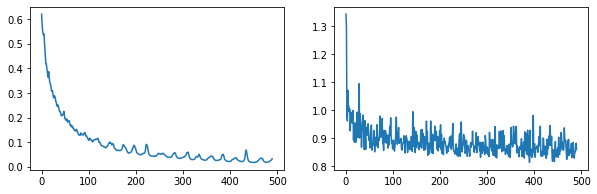

In [15]:
fig, ax = plt.subplots(1,2, figsize=(10,3))

ax[0].plot(train_history[10:])
ax[1].plot(val_history[10:])

In [16]:
model.eval()
loss = 0.
for i in np.random.permutation(len(test_data)//batch_size):
    start, end = i*batch_size, (i+1)*batch_size
    x,z = test_data[start:end].cuda(), test_targets[start:end].cuda()
    loss += ((model(x).detach() - z)**2).view(-1,64*64).sum(1).mean()
print('Final Loss: {:2f}'.format(loss/(len(test_data)//batch_size)))

Final Loss: 55.307095


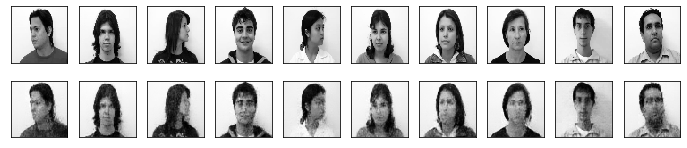

In [17]:
fig, ax = plt.subplots(2,10, figsize=(12,2.5))

model.eval()
reconstructions = model(train_data[0:10].cuda()).detach().cpu()
for i in range(10):
    ax[0,i].imshow(train_targets[i],cmap='Greys_r')
    ax[0,i].set_xticks([]); ax[0,i].set_yticks([])
    
    ax[1,i].imshow(reconstructions[i],cmap='Greys_r')
    ax[1,i].set_xticks([]); ax[1,i].set_yticks([])

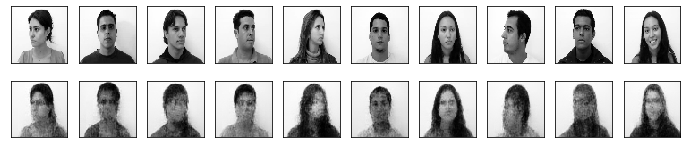

In [18]:
fig, ax = plt.subplots(2,10, figsize=(12,2.5))

model.eval()
reconstructions = model(test_data[0:10].cuda()).detach().cpu()
for i in range(10):    
    ax[0,i].imshow(test_targets[i],cmap='Greys_r')
    ax[0,i].set_xticks([]); ax[0,i].set_yticks([])
    
    ax[1,i].imshow(reconstructions[i],cmap='Greys_r')
    ax[1,i].set_xticks([]); ax[1,i].set_yticks([])